# ESM1 Plotting
The purpose of this notebook is to access the CMIP6 data sets and present the ESM1 temperature data from historic simulations. Dask functionality has been added to improve speed of calculations.

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36797")
client

Client Scheduler: tcp://127.0.0.1:36797 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 25.77 GB


#### Choices for data

In [2]:
variableId = 'thetao'
experimentId = 'historical'
sourceID = 'E3SM-1-0'

startTimeFull = '1850-01-16' #Start of full data set, included
endTimeFull = '2015-01-16' #End of full data set, excluded
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
timeS = '1950-01'
timeR = slice('1950-01', '1952-12')

#### Imports

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

#### Filtering for relevant data sets
ESM3 data sets

In [5]:
dfFilt = df[df.variable_id.eq(variableId) & df.experiment_id.eq(experimentId) & df.source_id.eq(sourceID)]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270827,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271451,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401325,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401333,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430599,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


Ocean area data to be used for averaging

In [6]:
dfArea = df[df.variable_id.eq('areacello') & df.source_id.eq('CESM2')]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

73 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
58575,CMIP,NCAR,CESM2,historical,r3i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
58598,CMIP,NCAR,CESM2,historical,r3i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
58783,CMIP,NCAR,CESM2,historical,r1i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
58785,CMIP,NCAR,CESM2,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
59076,CMIP,NCAR,CESM2,historical,r2i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308


#### Opening all datafiles
ESM3 data

In [7]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

Ocean Area data

In [8]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[0]), consolidated=True)
dataAreaRaw = dsArea.areacello

#### Combine data sets into one xarray

In [9]:
for i in range(fileCount):
    fileSetList[i]['time']=('time',np.arange(startTimeFull,endTimeFull,dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds',np.arange(startTimeFull,endTimeFull ,dtype='datetime64[M]'))
fileSet = xr.combine_nested(fileSetList, concat_dim='SetId')
fileSet

<xarray.Dataset>
Dimensions:    (SetId: 5, bnds: 2, bound: 2, lat: 180, lev: 60, lon: 360, time: 1980, time_bnds: 1980)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (SetId, lat, bnds, bound) float64 dask.array<chunksize=(1, 180, 2, 2), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
    lev_bnds   (SetId, lev, bnds, bound) float64 dask.array<chunksize=(1, 60, 2, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (SetId, lon, bnds, bound) float64 dask.array<chunksize=(1, 360, 2, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
  * time_bnds  (time_bnds) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
Dimensions without coordinates: SetId, bnds, bound
Data variables:
    thetao     (SetId, time, lev, lat, lon) float32 dask.array<chunksize=(1, 6, 60, 180, 360), meta=np.ndarray>

#### Selection of Data

In [10]:
dataFiltLatLev = fileSet.thetao.sel(lat=latSel, lev=5.0) #Selection of latitude and depth
dataFiltSingleTime = dataFiltLatLev.sel(time=timeS) #Selection of single date
dataFiltSingleTime = dataFiltSingleTime.reset_coords(drop=True) #Removes lev if single value
dataFiltFull = dataFiltLatLev.reset_coords(drop=True) #Removes lev if single value
dataFiltFull

,Array,Chunk
Bytes,869.62 MB,527.04 kB
Shape,"(5, 1980, 61, 360)","(1, 6, 61, 360)"
Count,6935 Tasks,1650 Chunks
Type,float32,numpy.ndarray


#### Calculation
Average temperature of fully filtered data

In [11]:
@delayed
def meanTemp(dataSet, dataAreaSet, totalArea):
    return (dataSet*dataAreaSet).sum(dim=['lon', 'lat']) / totalArea 

In [12]:
dataAreaSH = dataAreaRaw.sel(lat=latSel) #Selecting data for relevant latittude
totalArea = dataAreaSH.sum(dim=['lon', 'lat']) #Summing selected area

#Calculates mean temp for first data set
singleData = dataFiltSingleTime.sel(SetId=0) #Selecting data from first file
singleTemp = meanTemp(singleData, dataAreaSH, totalArea)

#Calculates mean temp for each data set for a single time
singleTemps = meanTemp(dataFiltSingleTime, dataAreaSH, totalArea)

#Calculates mean temps for time slice
rangeData = dataFiltFull.sel(time=timeR)
rangeTemps = (rangeData*dataAreaSH).sum(dim=['lon', 'lat']) / (totalArea) 
rangeTemps2 = meanTemp(rangeData, dataAreaSH, totalArea)

Single Temperature load: time = timeS, calculates mean Southern Ocean Temp for the first data set.

In [13]:
valuesSingleTemp = singleTemp.compute()
valuesSingleTemp.values

array([10.1088593])

Single Temperatures load: time = timeS, calculates mean Southern Ocean Temp for all data sets.

In [14]:
valuesSingleTemps = singleTemps.compute()
#valuesSingleTemps.values

In [15]:
print(timeR)
valuesRangeTemps = rangeTemps2.compute()
#valuesRangeTemps.values #Uncomment to show values
print("Calulations finished")

slice('1950-01', '1952-12', None)
Calulations finished


In [16]:
meanRangeTemps = valuesRangeTemps.mean('SetId')
stdRangeTemps = valuesRangeTemps.std('SetId')
meanRangeTemps.compute()
stdRangeTemps.compute()
print("Calculations finished")

Calculations finished


#### Presentation of data

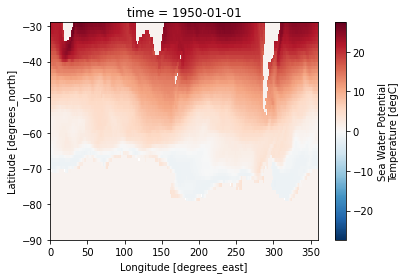

In [17]:
singleData.squeeze().plot()

Average Ocean temperature for presented data: 10.11 Celsius


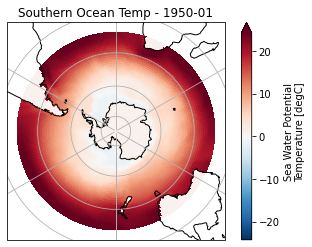

In [18]:
plt.figure(1)
p=singleData.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
p.axes.gridlines()
p.axes.coastlines()
plt.title("Southern Ocean Temp - " + str(timeS))

print("Average Ocean temperature for presented data: "+str(round(valuesSingleTemp.values[0],2))+" Celsius")

Text(0.5, 1.0, 'Sothern Ocean Temperature Deviation: 5 datasets')

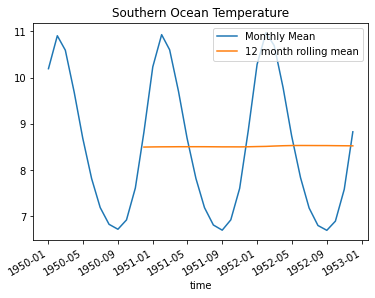

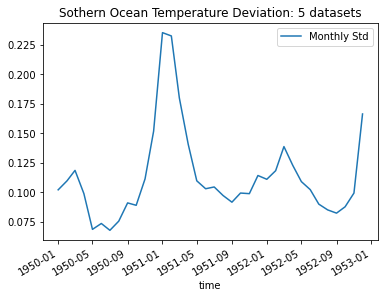

In [19]:
plt.figure(2)
meanRangeTemps.plot(label='Monthly Mean')
meanRangeTemps.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title("Southern Ocean Temperature")

plt.figure(3)
stdRangeTemps.plot(label='Monthly Std')
plt.legend()
plt.title("Sothern Ocean Temperature Deviation: "+str(fileCount)+" datasets")